# Human PBMCs - 10X dataset 

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import glob

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

results_file = './write/10X_hum_PBMCs_pp.h5ad'

scanpy==1.4.4+40.gbd5f862 anndata==0.6.22.post1 umap==0.3.9 numpy==1.15.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
%%R
# Load all the R libraries we will be using in the notebook
library(scran)

## Load 
Here we load the pre-processed datasets (which has been annotated), and the raw matrices (which won't be filtered on the gene level). 

### Raw data

In [5]:
# Set up data loading
file_base = '../Munich/datasets/human/10xPBMC/filtered_feature_bc_matrix/'
adata_raw = sc.read_10x_mtx(path=file_base, var_names='gene_symbols', make_unique=True, cache=True, gex_only=True )
adata_raw.X = adata_raw.X.toarray()
adata_raw.var_names_make_unique()
adata_raw.shape

... reading from cache file cache/..-Munich-datasets-human-10xPBMC-filtered_feature_bc_matrix-matrix.h5ad


(11769, 33538)

In [6]:
adata_raw.obs.head()

""
0
AAACCCAAGCGCCCAT-1
AAACCCAAGGTTCCGC-1
AAACCCACAGAGTTGG-1
AAACCCACAGGTATGG-1
AAACCCACATAGTCAC-1


In [7]:
adata_raw.var.head()

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression


In [8]:
#Annotate data
adata_raw.obs.index.rename('barcode', inplace=True)

adata_raw.obs['batch'] = ['10X']*adata_raw.n_obs
adata_raw.obs['study'] = ['10X']*adata_raw.n_obs
adata_raw.obs['chemistry'] = ['v3_10X']*adata_raw.n_obs
adata_raw.obs['tissue'] = ['PBMCs']*adata_raw.n_obs
adata_raw.obs['species'] = ['Human']*adata_raw.n_obs
adata_raw.obs['data_type'] = ['UMI']*adata_raw.n_obs
adata_raw.obs.head()

,batch,study,chemistry,tissue,species,data_type
barcode,,,,,,
AAACCCAAGCGCCCAT-1,10X,10X,v3_10X,PBMCs,Human,UMI
AAACCCAAGGTTCCGC-1,10X,10X,v3_10X,PBMCs,Human,UMI
AAACCCACAGAGTTGG-1,10X,10X,v3_10X,PBMCs,Human,UMI
AAACCCACAGGTATGG-1,10X,10X,v3_10X,PBMCs,Human,UMI
AAACCCACATAGTCAC-1,10X,10X,v3_10X,PBMCs,Human,UMI


In [9]:
adata_obs = adata_raw.obs.reset_index()
adata_obs['barcode'] = adata_obs['barcode']+['-10X']*adata_raw.n_obs
adata_obs.set_index('barcode', inplace = True)
adata_raw.obs = adata_obs
adata_raw.obs.head()

,batch,study,chemistry,tissue,species,data_type
barcode,,,,,,
AAACCCAAGCGCCCAT-1-10X,10X,10X,v3_10X,PBMCs,Human,UMI
AAACCCAAGGTTCCGC-1-10X,10X,10X,v3_10X,PBMCs,Human,UMI
AAACCCACAGAGTTGG-1-10X,10X,10X,v3_10X,PBMCs,Human,UMI
AAACCCACAGGTATGG-1-10X,10X,10X,v3_10X,PBMCs,Human,UMI
AAACCCACATAGTCAC-1-10X,10X,10X,v3_10X,PBMCs,Human,UMI


### Pre-processed data

In [13]:
file_paths = '../PBMC_human/write/pbmc10x_10kv3.h5ad'
adata_pp = sc.read(file_paths, cache=True)
adata_pp.shape

(10727, 15834)

In [12]:
adata_pp.obs.head()

,n_counts,log_counts,n_genes,mt_frac,size_factors,louvain_r1,louvain_r1_clust4_sub,louvain_r1_clust4_sub_12,final_annotation
index,,,,,,,,,
AAACCCAAGCGCCCAT-1,2204.0,7.698029,1087,0.023593,0.331484,0,0,0,CD4+ T cells
AAACCCAAGGTTCCGC-1,20090.0,9.907977,4200,0.065903,2.704702,14,14,14,Monocyte-derived dendritic cells
AAACCCACAGAGTTGG-1,5884.0,8.679992,1836,0.107580,0.669080,2,2,2,CD14+ Monocytes
AAACCCACAGGTATGG-1,5530.0,8.617943,2216,0.078481,0.944791,5,5,5,NK cells
AAACCCACATAGTCAC-1,5106.0,8.538172,1615,0.108304,0.569415,7,7,7,CD20+ B cells


In [14]:
adata_obs = adata_pp.obs.reset_index()
adata_obs = adata_obs[['index', 'final_annotation', 'n_counts', 'n_genes', 'mt_frac']].rename(columns = {'index':'barcode'})
adata_obs['barcode'] = adata_obs['barcode']+['-10X']*adata_pp.n_obs
adata_obs.set_index('barcode', inplace = True)
adata_pp.obs = adata_obs
adata_pp.obs.head()

,final_annotation,n_counts,n_genes,mt_frac
barcode,,,,
AAACCCAAGCGCCCAT-1-10X,CD4+ T cells,2204.0,1087,0.023593
AAACCCAAGGTTCCGC-1-10X,Monocyte-derived dendritic cells,20090.0,4200,0.065903
AAACCCACAGAGTTGG-1-10X,CD14+ Monocytes,5884.0,1836,0.107580
AAACCCACAGGTATGG-1-10X,NK cells,5530.0,2216,0.078481
AAACCCACATAGTCAC-1-10X,CD20+ B cells,5106.0,1615,0.108304


In [15]:
# Restrict to cells that passed QC and were annotated
adata_obs_raw = adata_raw.obs.reset_index()
adata_obs_pp = adata_pp.obs.reset_index()
adata_merged = adata_obs_raw.merge(adata_obs_pp, on='barcode', how='left')
adata_merged.set_index('barcode', inplace = True)
adata_raw.obs = adata_merged
adata_raw.obs.head()

,batch,study,chemistry,tissue,species,data_type,final_annotation,n_counts,n_genes,mt_frac
barcode,,,,,,,,,,
AAACCCAAGCGCCCAT-1-10X,10X,10X,v3_10X,PBMCs,Human,UMI,CD4+ T cells,2204.0,1087.0,0.023593
AAACCCAAGGTTCCGC-1-10X,10X,10X,v3_10X,PBMCs,Human,UMI,Monocyte-derived dendritic cells,20090.0,4200.0,0.065903
AAACCCACAGAGTTGG-1-10X,10X,10X,v3_10X,PBMCs,Human,UMI,CD14+ Monocytes,5884.0,1836.0,0.107580
AAACCCACAGGTATGG-1-10X,10X,10X,v3_10X,PBMCs,Human,UMI,NK cells,5530.0,2216.0,0.078481
AAACCCACATAGTCAC-1-10X,10X,10X,v3_10X,PBMCs,Human,UMI,CD20+ B cells,5106.0,1615.0,0.108304


In [16]:
adata_raw = adata_raw[~pd.isnull(adata_raw.obs['final_annotation'])]
adata_raw.shape

(10727, 33538)

### Normalization

In [17]:
# Exclude genes that are = 0 in all cells
#Filter genes:
print('Total number of genes: {:d}'.format(adata_raw.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_raw, min_cells=1)
print('Number of genes after cell filter: {:d}'.format(adata_raw.n_vars))

Total number of genes: 33538
filtered out 10572 genes that are detectedin less than 1 cells


Trying to set attribute `.var` of view, making a copy.


Number of genes after cell filter: 22966


In [18]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata_raw.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:07)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:01)


In [19]:
# Check if the minimum number of cells per cluster is < 21:in that case, sizes will be also passed as input to the normalization
adata_pp.obs['groups'].value_counts()

0     2098
1     1901
2     1448
3     1446
4     1026
5      893
6      730
7      558
8      317
9      209
10      80
11      21
Name: groups, dtype: int64

In [20]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata_raw.X.T

In [21]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [22]:
#Delete adata_pp
del adata_pp

... storing 'batch' as categorical
... storing 'study' as categorical
... storing 'chemistry' as categorical
... storing 'tissue' as categorical
... storing 'species' as categorical
... storing 'data_type' as categorical
... storing 'feature_types' as categorical


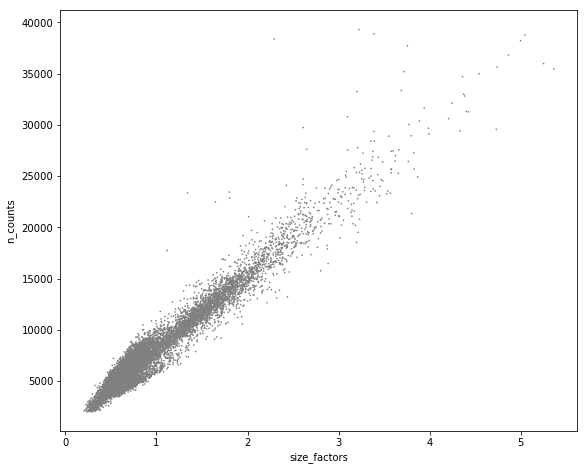

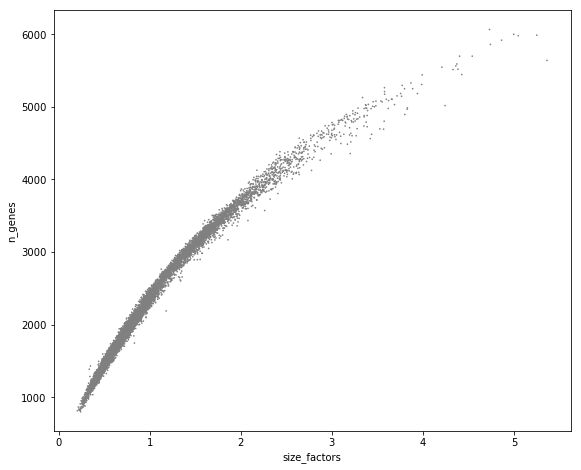

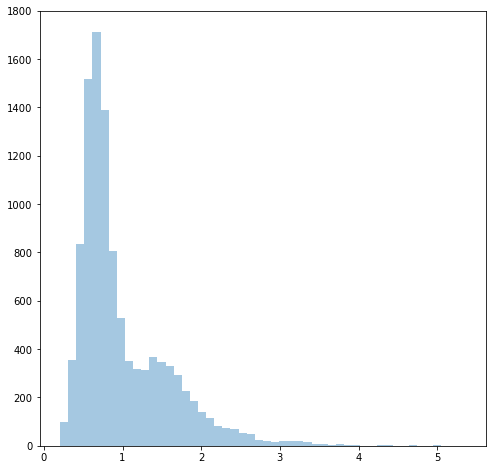

In [23]:
# Visualize the estimated size factors
adata_raw.obs['size_factors'] = size_factors

sc.pl.scatter(adata_raw, 'size_factors', 'n_counts')
sc.pl.scatter(adata_raw, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [24]:
#Keep the count data in a counts layer
adata_raw.layers["counts"] = adata_raw.X.copy()

In [25]:
#Normalize adata 
adata_raw.X /= adata_raw.obs['size_factors'].values[:,None]
sc.pp.log1p(adata_raw)

In [26]:
# Save final merged object
adata_raw.write(results_file)